<a href="https://colab.research.google.com/github/vagueau/Projet_python/blob/main/projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# importation des données

In [ ]:
!pip install pyarrow
!pip install xgboost
!pip install pandas

In [ ]:
import pyarrow.parquet as pq
import pandas as pd # bibliothèque de manipulation de données tabulaires
import numpy as np #  bibliothèque de manipulation des tableaux de données multidimensionnels
import matplotlib.pyplot as plt # bibliothèque de visualisation de données
import seaborn as sns #  bibliothèque de visualisation de données : graphiques statistiques
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import *
%matplotlib inline
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

IMPORTATION DES DONNEES

In [ ]:
# Lecture du fichier Parquet
table = pq.read_table("yellow_tripdata_2023-03.parquet")
table1 = pq.read_table("yellow_tripdata_2023-01.parquet")
# Conversion de la table en DataFrame pandas
dataframe = table.to_pandas()
dataframe1 = table1.to_pandas()
# Importer le fichier CSV dans un DataFrame
df_janvier = pd.read_excel("nyc_janvier.xlsx")
df_mars = pd.read_excel("nyc_mars.xlsx")

In [ ]:
dataframe.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2023-03-01 00:06:43,2023-03-01 00:16:43,1.0,0.00,1.0,N,238,42,2,8.6,1.0,0.5,0.00,0.0,1.0,11.10,0.0,0.00
1,2,2023-03-01 00:08:25,2023-03-01 00:39:30,2.0,12.40,1.0,N,138,231,1,52.7,6.0,0.5,12.54,0.0,1.0,76.49,2.5,1.25
2,1,2023-03-01 00:15:04,2023-03-01 00:29:26,0.0,3.30,1.0,N,140,186,1,18.4,3.5,0.5,4.65,0.0,1.0,28.05,2.5,0.00
3,1,2023-03-01 00:49:37,2023-03-01 01:01:05,1.0,2.90,1.0,N,140,43,1,15.6,3.5,0.5,4.10,0.0,1.0,24.70,2.5,0.00
4,2,2023-03-01 00:08:04,2023-03-01 00:11:06,1.0,1.23,1.0,N,79,137,1,7.2,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00


In [ ]:
dataframe.shape

(3403766, 19)

# nettoyage des données

NETTOYAGE DES DONNEES
- suppression variables calculées dans le tarif

In [ ]:
dataframe1.isnull().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          71743
trip_distance                0
RatecodeID               71743
store_and_fwd_flag       71743
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     71743
airport_fee              71743
dtype: int64

variable à prédire : total_amount
pour la prédire : ne pas prendre en compte les autres variables monétaires
suppression de :
- fare_amount
- extra
- mta_tax
- tip_amount
- tolls_amount
- improvement_surcharge
- congestion_surcharge
- airport_fee

In [ ]:
df_janvier.isnull().sum()

datetime       0
tempmax        0
tempmin        0
temp           0
humidity       0
precip         0
windgust       0
windspeed      0
cloudcover     0
visibility     0
solarenergy    0
dtype: int64

In [ ]:
df=dataframe.drop(['fare_amount', 'extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','congestion_surcharge','Airport_fee','RatecodeID'], axis=1)

In [ ]:
df1=dataframe1.drop(['fare_amount', 'extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','congestion_surcharge','airport_fee','RatecodeID'], axis=1)

In [ ]:
df.isnull().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          87619
trip_distance                0
store_and_fwd_flag       87619
PULocationID                 0
DOLocationID                 0
payment_type                 0
total_amount                 0
dtype: int64

In [ ]:
df=df.drop(['VendorID', 'store_and_fwd_flag'], axis=1)

In [ ]:
df.isnull().sum()

tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          87619
trip_distance                0
PULocationID                 0
DOLocationID                 0
payment_type                 0
total_amount                 0
dtype: int64

In [ ]:
df1=df1.drop(['VendorID', 'store_and_fwd_flag'], axis=1)

suppression des lignes vides pour maximiser la modélisation

### variable 'passenger_count'

In [ ]:
df.drop(df[(df['passenger_count']<=0)].index, inplace=True)
df.drop(df[(df['passenger_count']>=5)].index, inplace=True)
df1.drop(df1[(df1['passenger_count']<=0)].index, inplace=True)
df1.drop(df1[(df1['passenger_count']>=5)].index, inplace=True)

In [ ]:
moy=int(df['passenger_count'].mean())
moy1=int(df1['passenger_count'].mean())

In [ ]:
df['passenger_count'] = df['passenger_count'].replace(np.nan, moy) #remplacement par la moyenne du nbre de passager
df1['passenger_count'] = df1['passenger_count'].replace(np.nan, moy1) #remplacement par la moyenne du nbre de passager

In [ ]:
df.isnull().sum()
df1.isnull().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
PULocationID             0
DOLocationID             0
payment_type             0
total_amount             0
dtype: int64

CREATION DE VARIABLES
Détails des dates  :
- mois
- jour
- année
- heures
- minutes
- jour de la semaine
- durée du trajet

In [ ]:
df['mois'] = df.tpep_pickup_datetime.dt.month
df['jour'] = df.tpep_pickup_datetime.dt.day
df['annee'] = df.tpep_pickup_datetime.dt.year
df['heure'] = df.tpep_pickup_datetime.dt.hour
df['minute'] = df.tpep_pickup_datetime.dt.minute
df['joursemaine'] = df.tpep_pickup_datetime.dt.weekday

df['durée'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['duree_minute'] = df.durée.dt.total_seconds()/60

In [ ]:
df1['mois'] = df1.tpep_pickup_datetime.dt.month
df1['jour'] = df1.tpep_pickup_datetime.dt.day
df1['annee'] = df1.tpep_pickup_datetime.dt.year
df1['heure'] = df1.tpep_pickup_datetime.dt.hour
df1['minute'] = df1.tpep_pickup_datetime.dt.minute
df1['joursemaine'] = df1.tpep_pickup_datetime.dt.weekday

df1['durée'] = df1['tpep_dropoff_datetime'] - df1['tpep_pickup_datetime']
df1['duree_minute'] = df1.durée.dt.total_seconds()/60

In [ ]:
df=df.drop(['tpep_dropoff_datetime'], axis=1) #décomposation ok donc plus besoin des variables complètes
df1=df1.drop(['tpep_dropoff_datetime'], axis=1) #décomposation ok donc plus besoin des variables complètes

In [ ]:
df.tail(10)

,tpep_pickup_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,mois,jour,annee,heure,minute,joursemaine,durée,duree_minute
3403756,2023-03-31 23:43:56,1.0,5.17,113,151,0,41.25,3,31,2023,23,43,4,0 days 00:25:49,25.816667
3403757,2023-03-31 23:21:09,1.0,1.57,45,79,0,15.41,3,31,2023,23,21,4,0 days 00:10:16,10.266667
3403758,2023-03-31 23:44:00,1.0,5.52,230,223,0,36.94,3,31,2023,23,44,4,0 days 00:33:00,33.000000
3403759,2023-03-31 23:13:00,1.0,2.48,74,141,0,15.27,3,31,2023,23,13,4,0 days 00:12:00,12.000000
3403760,2023-03-31 23:11:21,1.0,4.56,231,80,0,27.58,3,31,2023,23,11,4,0 days 00:20:17,20.283333
3403761,2023-03-31 23:24:25,1.0,3.16,163,75,0,20.36,3,31,2023,23,24,4,0 days 00:16:29,16.483333
3403762,2023-03-31 23:24:50,1.0,6.89,125,198,0,53.90,3,31,2023,23,24,4,0 days 00:39:22,39.366667
3403763,2023-03-31 23:26:31,1.0,4.01,50,224,0,28.02,3,31,2023,23,26,4,0 days 00:23:08,23.133333
3403764,2023-03-31 23:07:51,1.0,1.31,113,158,0,16.01,3,31,2023,23,7,4,0 days 00:08:05,8.083333
3403765,2023-03-31 23:26:12,1.0,0.88,41,166,0,17.26,3,31,2023,23,26,4,0 days 00:05:35,5.583333


In [ ]:
df.describe()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,mois,jour,annee,heure,minute,joursemaine,durée,duree_minute
count,3.269727e+06,3.269727e+06,3.269727e+06,3.269727e+06,3.269727e+06,3.269727e+06,3.269727e+06,3.269727e+06,3.269727e+06,3.269727e+06,3.269727e+06,3.269727e+06,3269727,3.269727e+06
mean,1.272742e+00,3.937369e+00,1.654315e+02,1.640698e+02,1.186205e+00,2.786113e+01,3.000007e+00,1.588524e+01,2.023000e+03,1.435129e+01,2.954645e+01,3.025147e+00,0 days 00:16:50.470539589,1.684118e+01
std,6.153873e-01,1.955743e+02,6.370965e+01,6.968213e+01,5.360956e-01,2.293531e+01,1.336444e-02,8.983038e+00,3.525932e-02,5.764609e+00,1.734021e+01,1.847520e+00,0 days 00:42:36.249004864,4.260415e+01
min,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-9.829500e+02,1.000000e+00,1.000000e+00,2.001000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-1 days +16:03:45,-4.762500e+02
25%,1.000000e+00,1.060000e+00,1.320000e+02,1.140000e+02,1.000000e+00,1.570000e+01,3.000000e+00,8.000000e+00,2.023000e+03,1.100000e+01,1.400000e+01,2.000000e+00,0 days 00:07:25,7.416667e+00
50%,1.000000e+00,1.800000e+00,1.620000e+02,1.620000e+02,1.000000e+00,2.062000e+01,3.000000e+00,1.600000e+01,2.023000e+03,1.500000e+01,3.000000e+01,3.000000e+00,0 days 00:12:11,1.218333e+01
75%,1.000000e+00,3.400000e+00,2.330000e+02,2.340000e+02,1.000000e+00,2.976000e+01,3.000000e+00,2.400000e+01,2.023000e+03,1.900000e+01,4.500000e+01,4.000000e+00,0 days 00:19:41,1.968333e+01
max,4.000000e+00,2.169870e+05,2.650000e+02,2.650000e+02,5.000000e+00,1.000000e+03,1.200000e+01,3.100000e+01,2.023000e+03,2.300000e+01,5.900000e+01,6.000000e+00,3 days 21:57:43,5.637717e+03


## valeurs aberrantes

### variable 'durée'

In [ ]:
df['durée'].max()

Timedelta('3 days 21:57:43')

In [ ]:
df['durée'].max()
oneday=timedelta(days=0.25)
(df['durée']>oneday).value_counts()
df[df['durée']>oneday]
df1['durée'].max()
(df1['durée']>oneday).value_counts()
df1[df1['durée']>oneday]

,tpep_pickup_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,mois,jour,annee,heure,minute,joursemaine,durée,duree_minute
383,2023-01-01 00:36:07,1.0,1.20,234,234,1,16.40,1,1,2023,0,36,6,0 days 23:41:06,1421.100000
533,2023-01-01 00:21:42,2.0,3.05,48,140,1,28.52,1,1,2023,0,21,6,0 days 22:56:46,1376.766667
546,2023-01-01 00:11:01,1.0,1.68,138,129,1,23.34,1,1,2023,0,11,6,0 days 23:26:56,1406.933333
1244,2023-01-01 00:55:12,1.0,3.43,170,239,2,26.20,1,1,2023,0,55,6,0 days 23:57:00,1437.000000
2510,2023-01-01 00:20:17,1.0,2.58,246,231,2,19.90,1,1,2023,0,20,6,0 days 23:35:40,1415.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991021,2023-01-31 22:52:53,2.0,1.11,48,161,1,16.32,1,31,2023,22,52,1,0 days 23:58:50,1438.833333
2993830,2023-01-31 18:21:09,2.0,5.23,230,260,1,37.32,1,31,2023,18,21,1,0 days 23:21:39,1401.650000
2994073,2023-01-31 23:28:32,1.0,2.78,162,114,1,22.08,1,31,2023,23,28,1,0 days 23:50:09,1430.150000
2994500,2023-01-31 23:17:12,1.0,0.59,170,161,2,10.10,1,31,2023,23,17,1,0 days 23:47:25,1427.416667


In [ ]:
oneday=timedelta(days=1)
oneday

datetime.timedelta(days=1)

In [ ]:
df.drop(df[(df['durée']>oneday)].index, inplace=True)
df1.drop(df1[(df1['durée']>oneday)].index, inplace=True)

In [ ]:
df['durée'].max()

Timedelta('0 days 23:59:43')

In [ ]:
df=df.drop(['durée'], axis=1)
df1=df1.drop(['durée'], axis=1)

In [ ]:
df.shape
df.head()

,tpep_pickup_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,mois,jour,annee,heure,minute,joursemaine,duree_minute
0,2023-03-01 00:06:43,1.0,0.00,238,42,2,11.10,3,1,2023,0,6,2,10.000000
1,2023-03-01 00:08:25,2.0,12.40,138,231,1,76.49,3,1,2023,0,8,2,31.083333
3,2023-03-01 00:49:37,1.0,2.90,140,43,1,24.70,3,1,2023,0,49,2,11.466667
4,2023-03-01 00:08:04,1.0,1.23,79,137,1,14.64,3,1,2023,0,8,2,3.033333
5,2023-03-01 00:09:09,1.0,1.20,162,137,1,18.00,3,1,2023,0,9,2,8.416667


### variable 'total_amount'

In [ ]:
df.shape

(3269706, 14)

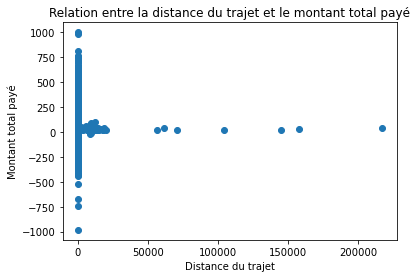

In [ ]:
plt.scatter(df['trip_distance'],df['total_amount'])
plt.xlabel('Distance du trajet')
plt.ylabel('Montant total payé')
plt.title('Relation entre la distance du trajet et le montant total payé')
plt.show()

In [ ]:
df=df[df['total_amount']<500]
df1=df1[df1['total_amount']<500]

In [ ]:
df=df[df['total_amount']>1]
df1=df1[df1['total_amount']>1]

In [ ]:
df.shape

(3239402, 14)

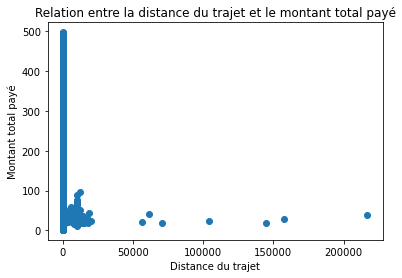

In [ ]:
plt.scatter(df['trip_distance'],df['total_amount'])
plt.xlabel('Distance du trajet')
plt.ylabel('Montant total payé')
plt.title('Relation entre la distance du trajet et le montant total payé')
plt.show()

### variable 'trip_distance'

In [ ]:
df['trip_distance'].mean()

3.941718817238111

In [ ]:
df['trip_distance'].max()

216986.96

In [ ]:
df[df['trip_distance']>250].value_counts()
df1[df1['trip_distance']>250].value_counts()

tpep_pickup_datetime  passenger_count  trip_distance  PULocationID  DOLocationID  payment_type  total_amount  mois  jour  annee  heure  minute  joursemaine  duree_minute
2023-01-01 16:23:00   1.0              2548.87        186           164           0             20.66         1     1     2023   16     23      6            14.0            1
2023-01-22 12:22:00   1.0              8096.42        170           79            0             22.64         1     22    2023   12     22      6            10.0            1
2023-01-24 08:30:00   1.0              4685.23        43            161           0             28.63         1     24    2023   8      30      1            19.0            1
2023-01-24 06:27:00   1.0              3253.99        230           90            0             27.05         1     24    2023   6      27      1            51.0            1
2023-01-23 17:14:00   1.0              258928.15      238           239           0             21.18         1     23    2023   1

In [ ]:
(df['trip_distance']>250).value_counts()
(df1['trip_distance']>250).value_counts()

False    2918962
True          68
Name: trip_distance, dtype: int64

In [ ]:
(df['trip_distance']<=0).value_counts()
(df1['trip_distance']<=0).value_counts()

False    2878076
True       40954
Name: trip_distance, dtype: int64

In [ ]:
df.drop(df[(df['trip_distance']>250)].index, inplace=True)
df1.drop(df1[(df1['trip_distance']>250)].index, inplace=True)

In [ ]:
df.drop(df[(df['trip_distance']<=0)].index, inplace=True)
df1.drop(df1[(df1['trip_distance']<=0)].index, inplace=True)

In [ ]:
df.shape

(3196487, 14)

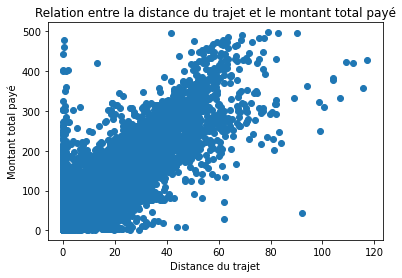

In [ ]:
plt.scatter(df['trip_distance'],df['total_amount'])
plt.xlabel('Distance du trajet')
plt.ylabel('Montant total payé')
plt.title('Relation entre la distance du trajet et le montant total payé')
plt.show()

# statistiques descriptives

In [ ]:
df.describe()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,mois,jour,annee,heure,minute,joursemaine,duree_minute
count,3.196487e+06,3.196487e+06,3.196487e+06,3.196487e+06,3.196487e+06,3.196487e+06,3.196487e+06,3.196487e+06,3.196487e+06,3.196487e+06,3.196487e+06,3.196487e+06,3.196487e+06
mean,1.273287e+00,3.479879e+00,1.655478e+02,1.641354e+02,1.163591e+00,2.826839e+01,3.000031e+00,1.588877e+01,2.023000e+03,1.436715e+01,2.954770e+01,3.024749e+00,1.692821e+01
std,6.149707e-01,4.486173e+00,6.360044e+01,6.963476e+01,4.790651e-01,2.197683e+01,1.258165e-02,8.984308e+00,3.566097e-02,5.752694e+00,1.733960e+01,1.846959e+00,4.185039e+01
min,1.000000e+00,1.000000e-02,1.000000e+00,1.000000e+00,0.000000e+00,1.010000e+00,1.000000e+00,1.000000e+00,2.001000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-4.762500e+02
25%,1.000000e+00,1.100000e+00,1.320000e+02,1.140000e+02,1.000000e+00,1.596000e+01,3.000000e+00,8.000000e+00,2.023000e+03,1.100000e+01,1.400000e+01,2.000000e+00,7.533333e+00
50%,1.000000e+00,1.800000e+00,1.620000e+02,1.620000e+02,1.000000e+00,2.070000e+01,3.000000e+00,1.600000e+01,2.023000e+03,1.500000e+01,3.000000e+01,3.000000e+00,1.226667e+01
75%,1.000000e+00,3.430000e+00,2.330000e+02,2.340000e+02,1.000000e+00,2.985000e+01,3.000000e+00,2.400000e+01,2.023000e+03,1.900000e+01,4.500000e+01,4.000000e+00,1.975000e+01
max,4.000000e+00,1.173300e+02,2.650000e+02,2.650000e+02,4.000000e+00,4.975500e+02,1.200000e+01,3.100000e+01,2.023000e+03,2.300000e+01,5.900000e+01,6.000000e+00,1.439717e+03


In [ ]:
df.dtypes

tpep_pickup_datetime    datetime64[ns]
passenger_count                float64
trip_distance                  float64
PULocationID                     int32
DOLocationID                     int32
payment_type                     int64
total_amount                   float64
mois                             int64
jour                             int64
annee                            int64
heure                            int64
minute                           int64
joursemaine                      int64
duree_minute                   float64
dtype: object

In [ ]:
df['passenger_count'].value_counts()

1.0    2552846
2.0     470834
3.0     115698
4.0      57109
Name: passenger_count, dtype: int64

<AxesSubplot:>

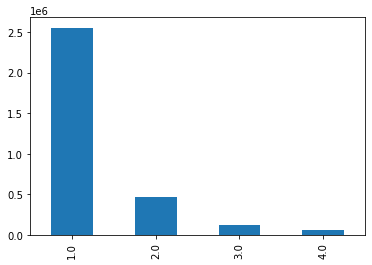

In [ ]:
df['passenger_count'].value_counts().plot.bar()

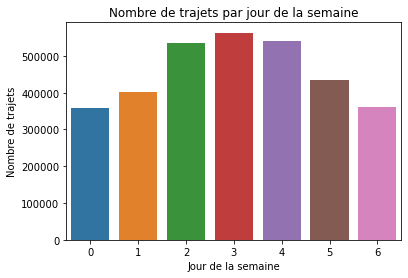

In [ ]:
sns.countplot(x='joursemaine', data=df)
plt.xlabel('Jour de la semaine')
plt.ylabel('Nombre de trajets')
plt.title('Nombre de trajets par jour de la semaine')
plt.xticks(rotation=0)
plt.show()

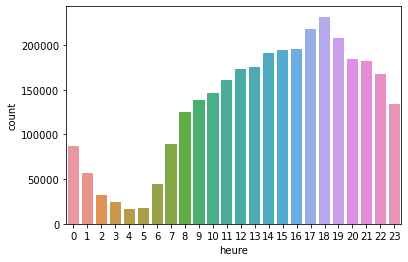

In [ ]:
sns.countplot(x='heure', data=df)
plt.show()

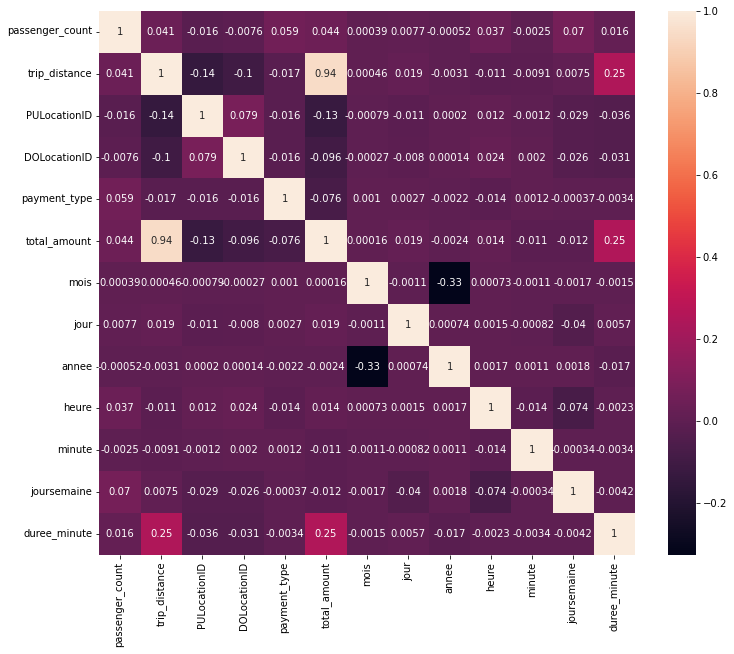

In [ ]:
corr_df = df.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True)
plt.show()

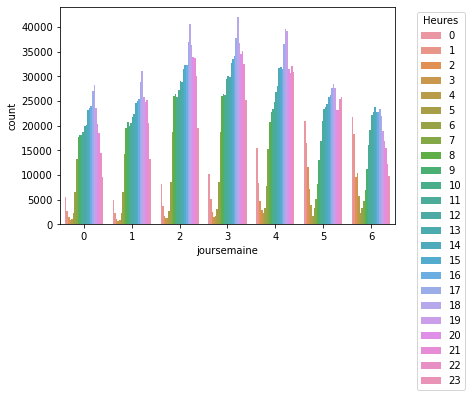

In [ ]:
sns.countplot(x='joursemaine',hue='heure', data=df)
#plt.legend().remove()
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left',title='Heures')
plt.show()

In [ ]:
df['total_amount'].mean()

28.268391749990403

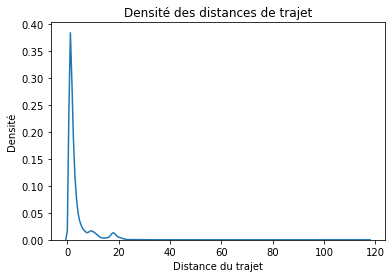

In [ ]:
sns.kdeplot(df['trip_distance'])
plt.xlabel('Distance du trajet')
plt.ylabel('Densité')
plt.title('Densité des distances de trajet')
plt.show()

In [ ]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3196487 entries, 1 to 3403765
Data columns (total 14 columns):
 #   Column                Dtype         
---  ------                -----         
 0   tpep_pickup_datetime  datetime64[ns]
 1   passenger_count       float64       
 2   trip_distance         float64       
 3   PULocationID          int32         
 4   DOLocationID          int32         
 5   payment_type          int64         
 6   total_amount          float64       
 7   mois                  int64         
 8   jour                  int64         
 9   annee                 int64         
 10  heure                 int64         
 11  minute                int64         
 12  joursemaine           int64         
 13  duree_minute          float64       
dtypes: datetime64[ns](1), float64(4), int32(2), int64(7)
memory usage: 341.4 MB


# création des 2 jeux de données : entraînement et test

In [ ]:
x=df.drop('total_amount', axis=1)

# fusion des deux dataframes


In [ ]:
df_janvier

,datetime,tempmax,tempmin,temp,humidity,precip,windgust,windspeed,cloudcover,visibility,solarenergy
0,2023-01-01,54.0,50.0,52.0,64.9,0.014,21.9,12.4,33.8,9.6,18.2
1,2023-01-02,56.0,47.0,52.3,62.3,0.018,10.3,7.5,55.7,9.6,13.8
2,2023-01-03,55.5,46.2,51.1,87.9,0.378,13.9,7.8,90.4,5.4,11.7
3,2023-01-04,65.7,48.6,57.9,79.7,0.018,15.0,9.5,67.6,8.2,14.7
4,2023-01-05,49.0,44.7,47.3,90.7,0.018,9.2,9.5,100.0,5.9,12.2
5,2023-01-06,47.9,40.1,44.3,78.5,0.266,23.0,11.8,93.0,7.7,12.0
6,2023-01-07,44.1,37.4,40.7,60.9,0.000,23.0,10.1,43.2,9.9,14.0
7,2023-01-08,40.7,33.2,37.4,53.0,0.000,17.2,15.0,18.7,9.9,17.5
8,2023-01-09,44.1,37.4,39.9,61.5,0.005,20.8,11.5,49.1,9.5,17.4
9,2023-01-10,41.0,38.3,39.7,54.7,0.000,19.5,8.4,87.8,9.8,11.8


In [ ]:
df_mars

,datetime,tempmax,tempmin,temp,humidity,precip,windgust,windspeed,cloudcover,visibility,solarenergy
0,2023-03-01,43.8,35.8,40.4,70.8,0.009,17.4,11.5,51.3,9.5,11.7
1,2023-03-02,53.1,39.8,44.9,75.8,0.000,34.3,12.4,60.5,6.7,6.2
2,2023-03-03,45.6,38.0,41.3,60.3,0.060,35.6,20.3,38.8,9.8,8.8
3,2023-03-04,46.9,39.8,42.8,81.2,0.454,41.2,28.3,99.8,8.7,7.2
4,2023-03-05,53.9,38.9,45.3,53.2,0.000,34.4,10.3,46.6,9.9,12.5
5,2023-03-06,53.8,39.8,46.6,41.1,0.000,45.4,11.2,19.4,9.9,15.0
6,2023-03-07,48.7,34.0,40.6,51.2,0.059,39.4,14.9,66.7,9.6,18.0
7,2023-03-08,48.7,32.0,39.8,51.3,0.000,37.8,9.6,17.4,9.9,17.5
8,2023-03-09,53.8,34.3,42.6,53.2,0.018,36.8,12.5,14.3,9.9,19.4
9,2023-03-10,44.9,37.9,41.4,67.7,0.018,41.4,11.0,62.4,9.8,6.4


In [ ]:
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'])

# Charger les données météorologiques dans un DataFrame (supposons que la colonne de date s'appelle 'DATE')
df_janvier['datetime'] = pd.to_datetime(df_janvier['datetime'], format="%d/%m/%Y")

# Fusionner les DataFrames en utilisant les colonnes de date comme clé
donnéesjanvier = pd.merge(df1, df_janvier, left_on=df1['tpep_pickup_datetime'].dt.date, right_on=df_janvier['datetime'].dt.date, how='inner')

# Supprimer les colonnes de date dupliquées
#df_merged.drop(['tpep_pickup_datetime', 'DATE'], axis=1, inplace=True)

# Afficher le DataFrame fusionné
donnéesjanvier.isnull().sum()

key_0                   0
tpep_pickup_datetime    0
passenger_count         0
trip_distance           0
PULocationID            0
DOLocationID            0
payment_type            0
total_amount            0
mois                    0
jour                    0
annee                   0
heure                   0
minute                  0
joursemaine             0
duree_minute            0
datetime                0
tempmax                 0
tempmin                 0
temp                    0
humidity                0
precip                  0
windgust                0
windspeed               0
cloudcover              0
visibility              0
solarenergy             0
dtype: int64

In [ ]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
# Charger les données météorologiques dans un DataFrame (supposons que la colonne de date s'appelle 'DATE')
df_mars['datetime'] = pd.to_datetime(df_mars['datetime'], format="%d/%m/%Y")
# Fusionner les DataFrames en utilisant les colonnes de date comme clé
donnéesmars = pd.merge(df, df_mars, left_on=df['tpep_pickup_datetime'].dt.date, right_on=df_mars['datetime'].dt.date, how='inner')
# Afficher le DataFrame fusionné
donnéesmars.isnull().sum()

key_0                   0
tpep_pickup_datetime    0
passenger_count         0
trip_distance           0
PULocationID            0
DOLocationID            0
payment_type            0
total_amount            0
mois                    0
jour                    0
annee                   0
heure                   0
minute                  0
joursemaine             0
duree_minute            0
datetime                0
tempmax                 0
tempmin                 0
temp                    0
humidity                0
precip                  0
windgust                0
windspeed               0
cloudcover              0
visibility              0
solarenergy             0
dtype: int64

In [ ]:
donnéesjanvier.drop(['tpep_pickup_datetime', 'key_0'], axis=1, inplace=True)
donnéesmars.drop(['tpep_pickup_datetime', 'key_0'], axis=1, inplace=True)

In [ ]:
donnéesjanvier.isnull().sum()

passenger_count    0
trip_distance      0
PULocationID       0
DOLocationID       0
payment_type       0
total_amount       0
mois               0
jour               0
annee              0
heure              0
minute             0
joursemaine        0
duree_minute       0
datetime           0
tempmax            0
tempmin            0
temp               0
humidity           0
precip             0
windgust           0
windspeed          0
cloudcover         0
visibility         0
solarenergy        0
dtype: int64

In [ ]:
"""donnéesmars = donnéesmars.sample(n=2000000, random_state=42,replace=True)
donnéesjanvier = donnéesjanvier.sample(n=2000000, random_state=42,replace=True)"""

'donnéesmars = donnéesmars.sample(n=2000000, random_state=42,replace=True)\ndonnéesjanvier = donnéesjanvier.sample(n=2000000, random_state=42,replace=True)'

In [ ]:
X_janvier=donnéesjanvier[['passenger_count','trip_distance','PULocationID','DOLocationID','mois','jour','annee','heure','minute','joursemaine','duree_minute','tempmax','tempmin','temp','humidity','precip','windgust','windspeed','visibility','solarenergy']]  # Caractéristiques
Y_janvier=donnéesjanvier['total_amount']
X_mars=donnéesmars[['passenger_count','trip_distance','PULocationID','DOLocationID','mois','jour','annee','heure','minute','joursemaine','duree_minute','tempmax','tempmin','temp','humidity','precip','windgust','windspeed','visibility','solarenergy']]  # Caractéristiques
Y_mars=donnéesmars['total_amount']

# modélisation

## Régression linéaire

In [ ]:
donnéesmars.isnull().sum()

passenger_count    0
trip_distance      0
PULocationID       0
DOLocationID       0
payment_type       0
total_amount       0
mois               0
jour               0
annee              0
heure              0
minute             0
joursemaine        0
duree_minute       0
datetime           0
tempmax            0
tempmin            0
temp               0
humidity           0
precip             0
windgust           0
windspeed          0
cloudcover         0
visibility         0
solarenergy        0
dtype: int64

## KNN

In [ ]:
# Séparation des caractéristiques (X) et de la variable cible (y)
X = df[['passenger_count','trip_distance','PULocationID','DOLocationID','mois','jour','annee','heure','minute','joursemaine','duree_minute']]  # Caractéristiques
Y = df['total_amount']  # Variable cible

# Séparation des données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# Création du modèle KNN
knn = KNeighborsRegressor(n_neighbors=11)  # Spécifiez le nombre de voisins (K) à utiliser
# Entraînement du modèle
knn.fit(X_train, y_train)
# Prédiction sur les données de test
y_pred = knn.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Erreur quadratique moyenne (MSE) :", mse)
print("Coefficient de détermination (R2) :", r2)


Erreur quadratique moyenne (MSE) : 40.096088896161135
Coefficient de détermination (R2) : 0.9171485617552978


## Avec méteo

In [ ]:
# Séparation des données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_mars, Y_mars, test_size=0.2, random_state=42)

In [ ]:
# Création du modèle KNN
knn = KNeighborsRegressor(n_neighbors=11)

In [ ]:
# Entraînement du modèle
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=11)

In [ ]:
# Prédiction sur les données de test
y_pred = knn.predict(X_test)

In [ ]:
# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Erreur quadratique moyenne (MSE) :", mse)
print("Coefficient de détermination (R2) :", r2)

Erreur quadratique moyenne (MSE) : 51.24072147455912
Coefficient de détermination (R2) : 0.8938201753654954


## Réseaux de neurones

In [ ]:
"""# Séparation des caractéristiques (X) et de la variable cible (y)
X = df[['passenger_count','trip_distance','PULocationID','DOLocationID','mois','jour','annee','heure','minute','joursemaine','duree_minute']]  # Caractéristiques
y = df['total_amount']  # Variable cible
# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Séparation des données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
# Création du modèle de réseau de neurones
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
# Compilation du modèle
model.compile(loss='mean_squared_error', optimizer='adam')
# Entraînement du modèle
model.fit(X_train, y_train, epochs=70, batch_size=32, verbose=1)
# Prédiction sur les données de test
y_pred = model.predict(X_test)
# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Erreur quadratique moyenne (MSE) :", mse)
print("Coefficient de détermination (R2) :", r2)"""

'# Séparation des caractéristiques (X) et de la variable cible (y)\nX = df[[\'passenger_count\',\'trip_distance\',\'PULocationID\',\'DOLocationID\',\'mois\',\'jour\',\'annee\',\'heure\',\'minute\',\'joursemaine\',\'duree_minute\']]  # Caractéristiques\ny = df[\'total_amount\']  # Variable cible\n# Normalisation des données\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)\n# Séparation des données d\'entraînement et de test\nX_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)\n# Création du modèle de réseau de neurones\nmodel = Sequential()\nmodel.add(Dense(32, activation=\'relu\', input_dim=X_train.shape[1]))\nmodel.add(Dense(16, activation=\'relu\'))\nmodel.add(Dense(8, activation=\'relu\'))\nmodel.add(Dense(1, activation=\'linear\'))\n# Compilation du modèle\nmodel.compile(loss=\'mean_squared_error\', optimizer=\'adam\')\n# Entraînement du modèle\nmodel.fit(X_train, y_train, epochs=70, batch_size=32, verbose=1)\n# Prédiction 

## Avec meteo

In [ ]:
"""# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_merged)

# Séparation des données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_merged, test_size=0.2, random_state=42)

# Création du modèle de réseau de neurones
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compilation du modèle
model.compile(loss='mean_squared_error', optimizer='adam')

# Entraînement du modèle
model.fit(X_train, y_train, epochs=70, batch_size=32, verbose=1)

# Prédiction sur les données de test
y_pred = model.predict(X_test)
# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Erreur quadratique moyenne (MSE) :", mse)
print("Coefficient de détermination (R2) :", r2)"""

'# Normalisation des données\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X_merged)\n\n# Séparation des données d\'entraînement et de test\nX_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_merged, test_size=0.2, random_state=42)\n\n# Création du modèle de réseau de neurones\nmodel = Sequential()\nmodel.add(Dense(32, activation=\'relu\', input_dim=X_train.shape[1]))\nmodel.add(Dense(16, activation=\'relu\'))\nmodel.add(Dense(8, activation=\'relu\'))\nmodel.add(Dense(1, activation=\'linear\'))\n\n# Compilation du modèle\nmodel.compile(loss=\'mean_squared_error\', optimizer=\'adam\')\n\n# Entraînement du modèle\nmodel.fit(X_train, y_train, epochs=70, batch_size=32, verbose=1)\n\n# Prédiction sur les données de test\ny_pred = model.predict(X_test)\n# Évaluation du modèle\nmse = mean_squared_error(y_test, y_pred)\nr2 = r2_score(y_test, y_pred)\nprint("Erreur quadratique moyenne (MSE) :", mse)\nprint("Coefficient de détermination (R2) :", r2)'

## XGboost


In [ ]:
# Sélectionnez vos fonctionnalités (variables indépendantes) et votre variable cible (variable dépendante)
X = df[['passenger_count','trip_distance','PULocationID','DOLocationID','mois','jour','annee','heure','minute','joursemaine','duree_minute']]
Y = df['total_amount']
# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# Créez le modèle XGBoost
xgb_model = xgb.XGBRegressor()
# Entraînez le modèle
xgb_model.fit(X_train, y_train)
# Faites des prédictions sur l'ensemble de test
y_pred = xgb_model.predict(X_test)
# Évaluez les performances du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
print("Erreur quadratique moyenne (MSE) :", mse)
print("Coefficient de détermination (R2) :", r2)

Erreur quadratique moyenne (MSE) : 25.54566580745246
Coefficient de détermination (R2) : 0.9472144238669477


## Avec méteo

In [ ]:
# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_mars, Y_mars, test_size=0.2, random_state=42)
# Créez le modèle XGBoost
xgb_model = xgb.XGBRegressor()

# Entraînez le modèle
xgb_model.fit(X_train, y_train)

# Faites des prédictions sur l'ensemble de test
y_pred = xgb_model.predict(X_test)

# Évaluez les performances du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Erreur quadratique moyenne (MSE) :", mse)
print("Coefficient de détermination (R2) :", r2)

Erreur quadratique moyenne (MSE) : 24.985887141226133
Coefficient de détermination (R2) : 0.948224829029581


In [ ]:
xgb_model.save_model('xgboost_model.bin')

In [ ]:
# Charger le modèle entraîné (assurez-vous d'avoir déjà entraîné le modèle et sauvegardé les poids)
model = xgb.XGBRegressor()
model.load_model('xgboost_model.bin')  # Remplacez 'xgboost_model.bin' par le nom de votre fichier de modèle

# Faire des prédictions sur les données de test
predictions = model.predict(X_janvier)
# Calculer le coefficient de détermination (R2)
r2 = r2_score(Y_janvier, predictions)
# Afficher le coefficient de détermination (R2)
print("Coefficient de détermination (R2) : ", r2)

Coefficient de détermination (R2) :  0.9431571584125991


In [ ]:
donnéesmars

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,mois,jour,annee,heure,...,tempmax,tempmin,temp,humidity,precip,windgust,windspeed,cloudcover,visibility,solarenergy
0,2.0,12.40,138,231,1,76.49,3,1,2023,0,...,43.8,35.8,40.4,70.8,0.009,17.4,11.5,51.3,9.5,11.7
1,1.0,2.90,140,43,1,24.70,3,1,2023,0,...,43.8,35.8,40.4,70.8,0.009,17.4,11.5,51.3,9.5,11.7
2,1.0,1.23,79,137,1,14.64,3,1,2023,0,...,43.8,35.8,40.4,70.8,0.009,17.4,11.5,51.3,9.5,11.7
3,1.0,1.20,162,137,1,18.00,3,1,2023,0,...,43.8,35.8,40.4,70.8,0.009,17.4,11.5,51.3,9.5,11.7
4,1.0,1.80,170,48,1,20.50,3,1,2023,0,...,43.8,35.8,40.4,70.8,0.009,17.4,11.5,51.3,9.5,11.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196377,1.0,3.16,163,75,0,20.36,3,31,2023,23,...,55.0,38.9,45.9,56.6,0.000,35.6,12.5,62.5,9.9,11.7
3196378,1.0,6.89,125,198,0,53.90,3,31,2023,23,...,55.0,38.9,45.9,56.6,0.000,35.6,12.5,62.5,9.9,11.7
3196379,1.0,4.01,50,224,0,28.02,3,31,2023,23,...,55.0,38.9,45.9,56.6,0.000,35.6,12.5,62.5,9.9,11.7
3196380,1.0,1.31,113,158,0,16.01,3,31,2023,23,...,55.0,38.9,45.9,56.6,0.000,35.6,12.5,62.5,9.9,11.7


In [ ]:
def predict_price(model):
    # Demander les informations nécessaires
    passenger_count = int(input("Nombre de passagers : "))
    trip_distance = float(input("Distance du trajet en miles : "))
    PULocationID = int(input("ID de l'emplacement de prise en charge : "))
    DOLocationID = int(input("ID de l'emplacement de dépose : "))
    mois = int(input("Mois (1-12) : "))
    jour = int(input("Jour du mois : "))
    annee = int(input("Année (YYYY) : "))
    heure = int(input("Heure (0-23) : "))
    minute = int(input("Minute (0-59) : "))
    joursemaine = int(input("Jour de la semaine (1-7) : "))
    duree_minute = int(input("Durée du trajet en minutes : "))
    tempmax = float(input("Température maximale en degrés fahrenheit : "))
    tempmin = float(input("Température minimale en degrés fahrenheit : "))
    temp = float(input("Température moyenne en degrés fahrenheit : "))
    humidity = int(input("Humidité en pourcentage : "))
    precip = float(input("Précipitations en mm : "))
    windgust = float(input("Rafales de vent en km/h : "))
    windspeed = float(input("Vitesse du vent en km/h : "))
    visibility = float(input("Visibilité en  : "))
    solarenergy = float(input("Énergie solaire en kWh/m^2 : "))

    # Créer un DataFrame avec les données saisies
    data = pd.DataFrame({'passenger_count': [passenger_count],'trip_distance': [trip_distance],'PULocationID': [PULocationID],
        'DOLocationID': [DOLocationID],'mois': [mois],'jour': [jour],'annee': [annee],'heure': [heure],'minute': [minute],
        'joursemaine': [joursemaine],'duree_minute': [duree_minute],'tempmax': [tempmax],'tempmin': [tempmin],'temp': [temp],'humidity': [humidity],
        'precip': [precip],'windgust': [windgust],'windspeed': [windspeed],'visibility': [visibility],'solarenergy': [solarenergy]})
    # Faire la prédiction
    prediction = model.predict(data)
    # Retourner la prédiction
    return prediction

# Utilisation de la fonction de prédiction
result = predict_price(model)
print("Le prix prédit est :", result)